#**Definizione di Nuove Strategie di Federated Learning con  Flower e Pytorch**

#**Installazione dei Pacchetti Richiesti**


*   Installazione di PyTorch (Torch)
*   Installazione di Torchvision per Computer Vision
*   Installazione di Flower per l'Implementazione del Federated Learning

In [1]:
!pip install -q flwr[simulation] torch torchvision opacus

#**All General Imports**

In [2]:
import os
import glob
import pandas as pd
import platform
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple
from opacus import PrivacyEngine
import math
from opacus.accountants.rdp import RDPAccountant


#**All Machine Learning Imports**

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
from torch import Tensor

#**All Federated Learning Imports**

In [4]:
import flwr as fl
import random

#**Reproducibility Params**

In [5]:
random_seed = 123
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(seed=random_seed)
torch.use_deterministic_algorithms(True)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(random_seed)

#**All Globals**

In [6]:
n_clients = 4
strategy_colors = ['red', 'green', 'blue', 'cyan']
strategy_list = ['fedavg', 'fedadagrad', 'fedadam', 'fedyogi']
strategy_type = 'fedavg'
loop_on_strategies = True     # se True
dataset = "har"                # cifar10, har
USE_DP = True # Use Differential privacy
target_epsilon = 10 # Specify target epsilon value

#**Hyper-parameters**

In [7]:
n_epochs = 2
n_rounds = 2
validation_split = 0.2
batch_size = 65

#**Initializations**

In [8]:
DEVICE = torch.device("cpu")  # Prova "cuda" per addestramento su GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

OS = platform.system()           # Sistema Operativo

strategies_acc = []

Training on cpu using PyTorch 2.0.1+cu118 and Flower 1.4.0


#**All General Functions Definitions**

In [9]:
def data_download(file_to_download, gdrive_code, OS, uncompress = True):
  if not os.path.exists(file_to_download):
    os.system('gdown --id "'+gdrive_code+'" --output '+file_to_download)
    if OS == "Linux" and uncompress:
        os.system('unzip -o -n "./'+file_to_download+'" -d '+os.path.dirname(file_to_download))
    return True
  else:
    return None

#**Data Download**


In [10]:
if dataset == "cifar10":
  transform = transforms.Compose(
      [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
  )
  trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
  testset = CIFAR10("./dataset", train=False, download=True, transform=transform)

  print("Training Set size: ", len(trainset))
  print("Test Set size: ", len(testset))
elif dataset == "har":
  out = data_download("./har_datasets_fl.zip", "1LUjU4yvBRh6FPBlIHRCD2uf5zMH6l9tC", OS)
  #urllib.request.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip", filename="har-data.zip")


#**Ripartizione del Training Set per il Federated Learning**

Il **Dataset** principale viene splittato **in N parti** tante quante il numero di client. Ciascun pezzo è costituito da differenti training e validation set, mentre il test set viene condiviso tra tutti i clients, di modo tale che esso sia sempre lo stesso e possa garantire confronti affidabili. Questo test set comune infatti permette di fare dei confronti tra differenti client con un unico e stabile test set.

In [11]:
if dataset == "cifar10":
  partition_size = len(trainset) // n_clients
  lengths = [partition_size] * n_clients
  datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

  print("Size of each Dataset Partition: ", partition_size)
  print("All Dataset Partitions sizes: ", lengths)

#**Preparazione dei Dati**

Per ciascun sottoinsieme, estraiamo un training set e un validation set e li wrappiamo all'interno di DataLoader, definendo il batch size, lo shuffle, ecc. Il testset viene condiviso tra tutti i client, mentre train e validation set sono specifici per ogni client: questo è vero sia per il dataset di benchmark cifar10 che per il dataset di human activity recognition (har).

In [12]:
trainloaders = []
valloaders = []

if dataset == "cifar10":
  for ds in datasets:
      len_val = len(ds) // validation_rate
      len_train = len(ds) - len_val
      lengths = [len_train, len_val]
      ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
      trainloaders.append(DataLoader(ds_train, batch_size = batch_size, shuffle=True))
      valloaders.append(DataLoader(ds_val, batch_size = batch_size))

  testloader = DataLoader(testset, batch_size = batch_size)
elif dataset == "har":
  subdirectories = [f.path for f in os.scandir('./har_datasets_fl') if f.is_dir()]

  global_X_testset = pd.DataFrame()
  global_y_testset = pd.DataFrame()

  for subdirectory in subdirectories:
    fold_number = os.path.basename(subdirectory).split('-')[0].strip()
    print("Reading : ", subdirectory)

    trainset = pd.read_csv(subdirectory+'/train/'+fold_number+'_ALL_train.csv', delimiter = ';')
    valset = trainset[-int(len(trainset)*validation_split):]
    trainset = trainset[0:-int(len(trainset)*validation_split)]
    testset = pd.read_csv(subdirectory+'/test/'+fold_number+'_ALL_test.csv', delimiter = ';')

    '''
    print(trainset.shape)
    print(valset.shape)
    print(testset.shape)
    '''

    X_train = pd.concat([trainset[str(i)] for i in range(561)], axis = 1)
    y_train = trainset['Y'] - 1

    X_val = pd.concat([valset[str(i)] for i in range(561)], axis = 1)
    y_val = valset['Y'] - 1

    X_test = pd.concat([testset[str(i)] for i in range(561)], axis = 1)
    y_test = testset['Y'] - 1

    global_X_testset = pd.concat([global_X_testset, X_test], axis=0)
    global_y_testset = pd.concat([global_y_testset, y_test], axis=0)

    training_data = torch.utils.data.TensorDataset(torch.tensor(X_train.values).float(), torch.as_tensor(y_train.values).squeeze())
    val_data = torch.utils.data.TensorDataset(torch.tensor(X_val.values).float(), torch.as_tensor(y_val.values).squeeze())
    trainloaders.append(DataLoader(training_data, batch_size=batch_size))
    valloaders.append(DataLoader(val_data, batch_size=batch_size))

test_data = torch.utils.data.TensorDataset(torch.tensor(global_X_testset.values).float(), torch.as_tensor(global_y_testset.values).squeeze())
test_dataloader = DataLoader(test_data, batch_size=batch_size)


Reading :  ./har_datasets_fl/1 - ISTAT
Reading :  ./har_datasets_fl/0 - CBS
Reading :  ./har_datasets_fl/3 - STATCAN
Reading :  ./har_datasets_fl/2 - ONS


In [13]:
print("Number of Training Subsets: ", len(trainloaders))

Number of Training Subsets:  4


In [14]:
print("Number of Validation Subsets: ", len(trainloaders))

Number of Validation Subsets:  4


#**Definizione del Modello**

In [15]:
class ConvNet(nn.Module):
    def __init__(self) -> None:
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class MLP(nn.Module):
    """ Multi Layer Perceptron """
    def __init__(self) -> None:
        super(MLP, self).__init__()
        #self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(561, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 6)
        )

    def forward(self, x: Tensor) -> Tensor:
        #x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Crea un'istanza del modello e ne ottiene i parametri
if dataset == "cifar10":
  Net = ConvNet
elif dataset == "har":
  Net = MLP

#**Addestramento del Modello**

Nel **federated learning**, il server manda i parametri globali del modello ai suoi client, e i client aggiornano il modello locale mediante i parametri ricevuti dal server.

Dunque i client addestrano il modello sui dati locali (i quali influenza i parametri del modello localmente) e mandano i parametri del modello cambiati/aggiornati di nuovo indietro verso il server (o in alternativa, mandano i gradienti verso il server, non in questo caso i parametri completi del modello).

Abbiamo bisogno pertanto di due funzioni di supporto per aggiornare il modello locale con i parametri ricevuti dal server (set_parameters) e ottenere i parametri aggiornati dal modello locale (get_parameters). Le seguenti funzioni eseguno queste operazioni per il modello Pytorch precedentemente definito.

In sostanza usuamo **state_dict** per accedere ai tensori dei parametri del modello PyTorch. I tensori del parametro sono poi convertiti a/da una lista di array Numpy (che Flower è in grado di serializzare/deserializzare).

##**Aggiornamento dei Parametri del Modello**

In [16]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

##**Addestramento**

In [17]:

def train(net, trainloader, epochs: int):
    training_size = len(trainloader.dataset)
    batch_size = trainloader.batch_size

    # Modify target_epsilon and target_delta here

    target_delta = 1e-5

    max_grad_norm = 1.0
    noise_multiplier = 1.0  # This value will be used to initialize the PrivacyEngine, but it will be modified automatically to reach the target epsilon

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())

    if USE_DP:
      privacy_engine = PrivacyEngine(accountant = 'rdp')

      model, optimizer, dataloader = privacy_engine.make_private_with_epsilon(
          module=net,
          optimizer=optimizer,
          data_loader=trainloader,
          target_epsilon=target_epsilon,
          target_delta=target_delta,
          epochs=epochs,
          max_grad_norm=max_grad_norm,
      )

    model = model.to(DEVICE)

    model.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()

        epoch_loss /= len(dataloader.dataset)

    # After training, you can get the final epsilon
    final_epsilon = privacy_engine.get_epsilon(delta=target_delta)
    print(f"The target epsilon was: {target_epsilon}")
    print(f"The final epsilon is: {final_epsilon}")


#**Model Testing**

In [18]:
from sklearn.metrics import f1_score

def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()

    all_labels = []
    all_predicted = []

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.append(labels.cpu())
            all_predicted.append(predicted.cpu())

    all_labels = torch.cat(all_labels) # concatenate all labels tensors
    all_predicted = torch.cat(all_predicted) # concatenate all predicted tensors

    loss /= len(testloader.dataset)
    accuracy = correct / total

    # Calculate F1 score. Need to convert tensors to numpy arrays
    f1_score_value_micro = f1_score(all_labels.numpy(), all_predicted.numpy(), average='micro')
    f1_score_value_macro = f1_score(all_labels.numpy(), all_predicted.numpy(), average='macro')
    f1_score_value_perclass = f1_score(all_labels.numpy(), all_predicted.numpy(), average=None)

    return accuracy, loss, f1_score_value_micro, f1_score_value_macro, f1_score_value_perclass


#**Implementazione del Client Flower**

Come sappiamo i sistemi di Federated learning sono costituiti da una parte client e una parte serve. In Flower, creiamo i client implementando delle sottoclassi di `flwr.client.Client` o `flwr.client.NumPyClient`.

Usiamo adesso `NumPyClient` dal momento che è più facile da implementare.

Per implementare il client, creiamo una sottoclasse `flwr.client.NumPyClient` e implementiamo 3 metodi `get_parameters`, `fit`, and `evaluate`:

* `get_parameters`: Ritorna i parametri del modello attuale.
* `fit`: Riceve i parametri del modello dal server, addestra i parametri sui dati locali, e ritorna i parametri del modello aggiornati verso il server.
* `evaluate`: Receve i parametri del modello dal server, valuta i parametri del modello sui dati locali, e ritorna il risultato della valutazione al server.


In [19]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=n_epochs)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        accuracy, loss, f1_score_value_micro, f1_score_value_macro, f1_score_value_perclass = test(self.net, self.valloader)
        print(f"[Client {self.cid}] loss: {loss}, accuracy: {accuracy}, f1_score_micro: {f1_score_value_micro}, f1_score_macro: {f1_score_value_macro}, f1_score_perclass: {f1_score_value_perclass}")  # Add this line

        return float(loss), len(self.valloader), {
                                                    "accuracy": float(accuracy),
                                                    "f1_score_micro": float(f1_score_value_micro),
                                                    "f1_score_macro": float(f1_score_value_macro),
                                                    "f1_score_perclass": [float(score) for score in f1_score_value_perclass]}

def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader)

Flower, di default, inizializza il modello gobale richiedendo un client casuale per l'inizializzazione dei parametri. In molti casi, vogliamo più controllo sull'inizializzazione dei parametri. Flower quindi permette quindi di passare i parametri inziali alla Strategia.

Quando chiamiamo **start_simulation**, diciamo a Flower che ci sono 4 client. Flower aòòpra va avanti e richiede la strategia  FedAvg per selezionare i client. FedAvg sa che dovrebbe selezionalre il 100% dei client disponibili (fraction_fit=1.0), così va avanti e seleziona 4 client casualmente (cioè 100% dei 4).

#**Selezione della Strategia di Aggregazione Built-In**

INFO flwr 2023-06-29 15:05:50,774 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=2, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=2, round_timeout=None)



Analyzing Strategy... :  Fedavg


2023-06-29 15:05:57,673	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-06-29 15:06:00,264 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'GPU': 1.0, 'memory': 7867814708.0, 'object_store_memory': 3933907353.0, 'CPU': 2.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'GPU': 1.0, 'memory': 7867814708.0, 'object_store_memory': 3933907353.0, 'CPU': 2.0}
INFO flwr 2023-06-29 15:06:00,273 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-06-29 15:06:00,278 | server.py:269 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2023-06-29 15:06:00,285 | server.py:88 | Evaluating initial parameters
INFO:flwr:Evaluating initial parameters
INFO flwr 2023-06-29 15:06:00,290 | server.py:101 | FL starting
INFO:flwr:FL starting
DEBUG flwr 2023-06-29 15:06:00,297 | server.py:218 | fit_round 1: stra

(launch_and_fit pid=6257) [Client 2] fit, config: {}


(launch_and_fit pid=6257) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
(launch_and_fit pid=6257)   warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


(launch_and_fit pid=6257) The target epsilon was: 10
(launch_and_fit pid=6257) The final epsilon is: 9.995721631459373
(launch_and_fit pid=6256) The final epsilon is: 9.995721631459373
(launch_and_fit pid=6257) [Client 0] fit, config: {}


DEBUG flwr 2023-06-29 15:07:02,537 | server.py:232 | fit_round 1 received 4 results and 0 failures
DEBUG:flwr:fit_round 1 received 4 results and 0 failures


(launch_and_fit pid=6257) The target epsilon was: 10 [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(launch_and_fit pid=6257) The final epsilon is: 9.995721631459373 [repeated 2x across cluster]
(launch_and_fit pid=6256) The final epsilon is: 9.995721631459373


WARNING flwr 2023-06-29 15:07:02,562 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-29 15:07:02,569 | server.py:168 | evaluate_round 1: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=6256) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=6256) [Client 1] loss: 0.0222147985765005, accuracy: 0.547683923705722, f1_score_micro: 0.547683923705722, f1_score_macro: 0.36189626234248945, f1_score_perclass: [0.52682927 0.         0.         0.         0.71287129 0.93167702]


DEBUG flwr 2023-06-29 15:07:03,190 | server.py:182 | evaluate_round 1 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 4 results and 0 failures
DEBUG flwr 2023-06-29 15:07:03,197 | server.py:218 | fit_round 2: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 2: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=6256) [Client 2] loss: 0.02249245942450999, accuracy: 0.5177111716621253, f1_score_micro: 0.5177111716621253, f1_score_macro: 0.35564932978367675, f1_score_perclass: [0.50442478 0.         0.         0.         0.7032967  0.9261745 ]
(launch_and_fit pid=6256) [Client 2] fit, config: {}


(launch_and_fit pid=6256) /usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 2x across cluster]
(launch_and_fit pid=6256)   warnings.warn( [repeated 4x across cluster]
(launch_and_fit pid=6256) /usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound. [repeated 2x across cluster]
(launch_and_fit pid=6256)   warnings.warn(
(launch_and_fit pid=6256)   warnings.warn(
(launch_and_fit pid=6257) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be rem

(launch_and_fit pid=6257) The target epsilon was: 10 [repeated 2x across cluster]
(launch_and_fit pid=6257) The final epsilon is: 9.995721631459373 [repeated 2x across cluster]
(launch_and_evaluate pid=6257) [Client 3] evaluate, config: {} [repeated 3x across cluster]
(launch_and_evaluate pid=6257) [Client 3] loss: 0.022441010709029777, accuracy: 0.5340599455040872, f1_score_micro: 0.5340599455040872, f1_score_macro: 0.362730514351056, f1_score_perclass: [0.51502146 0.         0.         0.         0.71264368 0.94871795] [repeated 2x across cluster]
(launch_and_fit pid=6257) The final epsilon is: 9.995721631459373
(launch_and_fit pid=6257) [Client 3] fit, config: {}
(launch_and_fit pid=6257) The target epsilon was: 10 [repeated 2x across cluster]
(launch_and_fit pid=6257) The final epsilon is: 9.995721631459373 [repeated 2x across cluster]
(launch_and_fit pid=6256) The final epsilon is: 9.995721631459373


DEBUG flwr 2023-06-29 15:07:45,380 | server.py:232 | fit_round 2 received 4 results and 0 failures
DEBUG:flwr:fit_round 2 received 4 results and 0 failures
DEBUG flwr 2023-06-29 15:07:45,400 | server.py:168 | evaluate_round 2: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 2: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-06-29 15:07:45,815 | server.py:182 | evaluate_round 2 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 4 results and 0 failures
INFO flwr 2023-06-29 15:07:45,818 | server.py:147 | FL finished in 105.52182098599997
INFO:flwr:FL finished in 105.52182098599997
INFO flwr 2023-06-29 15:07:45,834 | app.py:218 | app_fit: losses_distributed [(1, 0.022370503936216684), (2, 0.017384915975523902)]
INFO:flwr:app_fit: losses_distributed [(1, 0.022370503936216684), (2, 0.017384915975523902)]
INFO flwr 2023-06-29 15:07:45,839 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fit: metrics_distributed_fit {}
INFO flwr 2023-0

(launch_and_evaluate pid=6256) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=6256) [Client 3] loss: 0.01742968572257975, accuracy: 0.6212534059945504, f1_score_micro: 0.6212534059945504, f1_score_macro: 0.5418931430653129, f1_score_perclass: [0.53811659 0.28125    0.03389831 0.70491803 0.71304348 0.98013245]


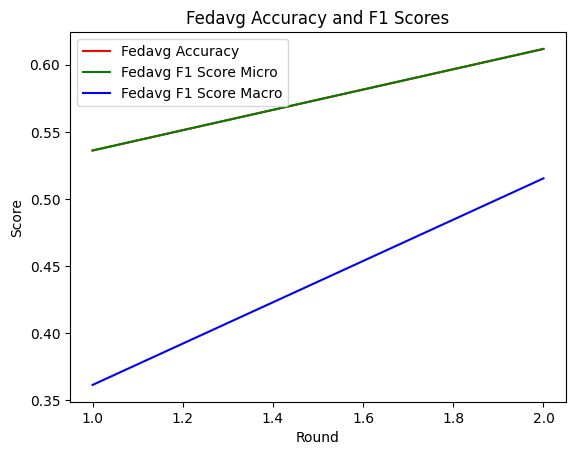

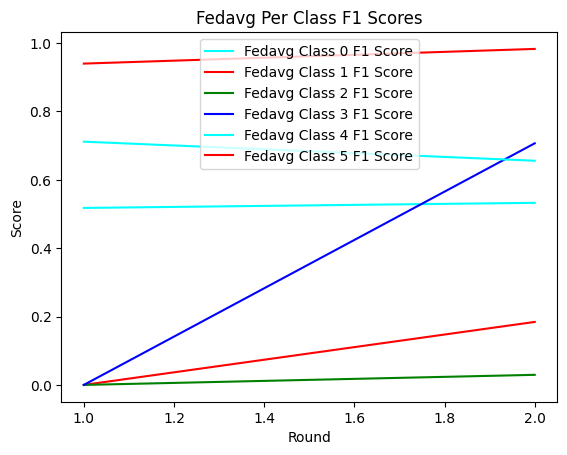

INFO flwr 2023-06-29 15:07:47,248 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=2, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=2, round_timeout=None)



Analyzing Strategy... :  Fedadagrad
(launch_and_fit pid=6256) The target epsilon was: 10
(launch_and_fit pid=6256) The final epsilon is: 9.995721631459373
(launch_and_evaluate pid=6257) [Client 0] evaluate, config: {} [repeated 3x across cluster]
(launch_and_evaluate pid=6257) [Client 0] loss: 0.017403260238813768, accuracy: 0.6103542234332425, f1_score_micro: 0.6103542234332425, f1_score_macro: 0.5056649600973359, f1_score_perclass: [0.53211009 0.09836066 0.04166667 0.71328671 0.65546218 0.99310345] [repeated 3x across cluster]


(launch_and_fit pid=6257) /usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(launch_and_fit pid=6257)   warnings.warn( [repeated 2x across cluster]
(launch_and_fit pid=6257) /usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
(launch_and_fit pid=6256) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
(laun

(launch_and_fit pid=7024) [Client 1] fit, config: {}


(launch_and_fit pid=7023) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
(launch_and_fit pid=7023)   warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


(launch_and_fit pid=7023) The target epsilon was: 10
(launch_and_fit pid=7023) The final epsilon is: 9.995721631459373
(launch_and_fit pid=7023) The final epsilon is: 9.995721631459373
(launch_and_fit pid=7023) [Client 3] fit, config: {}
(launch_and_fit pid=7023) The target epsilon was: 10 [repeated 2x across cluster]
(launch_and_fit pid=7023) The final epsilon is: 9.995721631459373 [repeated 2x across cluster]
(launch_and_fit pid=7024) The final epsilon is: 9.995721631459373


DEBUG flwr 2023-06-29 15:09:05,237 | server.py:232 | fit_round 1 received 4 results and 0 failures
DEBUG:flwr:fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-06-29 15:09:05,261 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-29 15:09:05,277 | server.py:168 | evaluate_round 1: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 1: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-06-29 15:09:05,651 | server.py:182 | evaluate_round 1 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 4 results and 0 failures
DEBUG flwr 2023-06-29 15:09:05,655 | server.py:218 | fit_round 2: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 2: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=7023) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=7023) [Client 3] loss: 0.1152682278396648, accuracy: 0.3133514986376022, f1_score_micro: 0.3133514986376022, f1_score_macro: 0.17064684990775317, f1_score_perclass: [0.         0.48245614 0.         0.4691358  0.         0.07228916]


(launch_and_fit pid=7023) /usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 2x across cluster]
(launch_and_fit pid=7023)   warnings.warn( [repeated 4x across cluster]
(launch_and_fit pid=7023) /usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound. [repeated 2x across cluster]
(launch_and_fit pid=7024)   warnings.warn(
(launch_and_fit pid=7024)   warnings.warn(


(launch_and_fit pid=7023) [Client 2] fit, config: {}


(launch_and_fit pid=7023) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
(launch_and_fit pid=7023)   warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


(launch_and_fit pid=7023) The target epsilon was: 10 [repeated 2x across cluster]
(launch_and_fit pid=7023) The final epsilon is: 9.995721631459373 [repeated 2x across cluster]
(launch_and_evaluate pid=7024) [Client 2] evaluate, config: {} [repeated 3x across cluster]
(launch_and_evaluate pid=7024) [Client 2] loss: 0.10833469593557415, accuracy: 0.3460490463215259, f1_score_micro: 0.3460490463215259, f1_score_macro: 0.19058251319355302, f1_score_perclass: [0.         0.51754386 0.         0.504      0.         0.12195122] [repeated 3x across cluster]
(launch_and_fit pid=7024) The final epsilon is: 9.995721631459373
(launch_and_fit pid=7023) [Client 1] fit, config: {}
(launch_and_fit pid=7024) The target epsilon was: 10 [repeated 2x across cluster]
(launch_and_fit pid=7024) The final epsilon is: 9.995721631459373 [repeated 2x across cluster]
(launch_and_fit pid=7024) The final epsilon is: 9.995721631459373


DEBUG flwr 2023-06-29 15:09:51,155 | server.py:232 | fit_round 2 received 4 results and 0 failures
DEBUG:flwr:fit_round 2 received 4 results and 0 failures
DEBUG flwr 2023-06-29 15:09:51,187 | server.py:168 | evaluate_round 2: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 2: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=7023) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7023) [Client 2] loss: 1.2197296703868732, accuracy: 0.3188010899182561, f1_score_micro: 0.3188010899182561, f1_score_macro: 0.16100451596634802, f1_score_perclass: [0.         0.         0.47747748 0.         0.48854962 0.        ]


DEBUG flwr 2023-06-29 15:09:51,959 | server.py:182 | evaluate_round 2 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 4 results and 0 failures
INFO flwr 2023-06-29 15:09:51,963 | server.py:147 | FL finished in 116.95599656199988
INFO:flwr:FL finished in 116.95599656199988
INFO flwr 2023-06-29 15:09:51,967 | app.py:218 | app_fit: losses_distributed [(1, 0.1071518604372113), (2, 1.185186396502669)]
INFO:flwr:app_fit: losses_distributed [(1, 0.1071518604372113), (2, 1.185186396502669)]
INFO flwr 2023-06-29 15:09:51,969 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-29 15:09:51,974 | app.py:220 | app_fit: metrics_distributed {'accuracy': [(1, 0.33310626702997276), (2, 0.32152588555858314)], 'f1_score_micro': [(1, 0.33310626702997276), (2, 0.32152588555858314)], 'f1_score_macro': [(1, 0.18348633054851282), (2, 0.16158915111805244)], 'f1_score_perclass': [(1, [0.0, 0.5074593432193898, 0.0, 0.4870263193

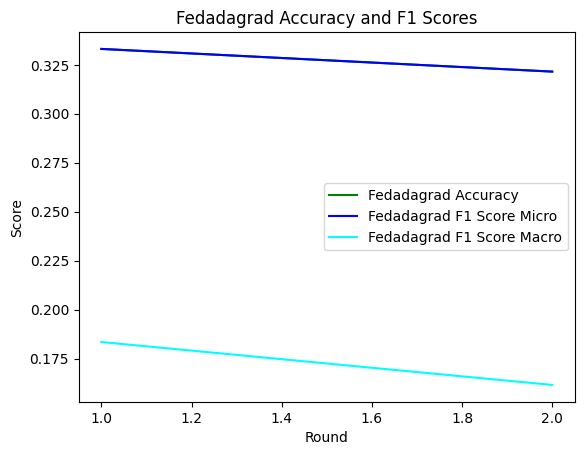

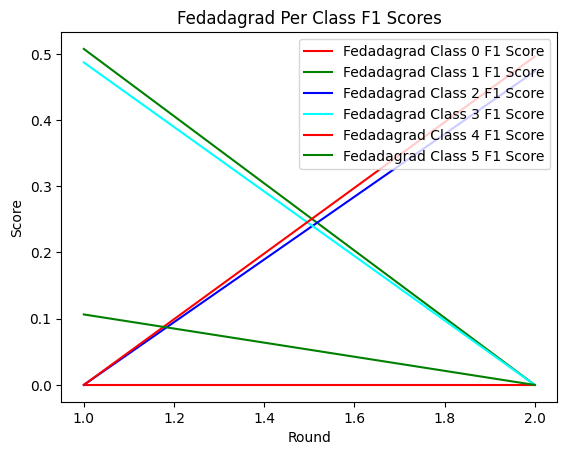

INFO flwr 2023-06-29 15:09:53,383 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=2, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=2, round_timeout=None)



Analyzing Strategy... :  Fedadam
(launch_and_fit pid=7023) The target epsilon was: 10
(launch_and_fit pid=7023) The final epsilon is: 9.995721631459373
(launch_and_evaluate pid=7024) [Client 1] evaluate, config: {} [repeated 3x across cluster]
(launch_and_evaluate pid=7024) [Client 1] loss: 1.1703022325396213, accuracy: 0.3215258855585831, f1_score_micro: 0.3215258855585831, f1_score_macro: 0.16116751269035534, f1_score_perclass: [0.         0.         0.46700508 0.         0.5        0.        ] [repeated 3x across cluster]


(launch_and_fit pid=7024) /usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(launch_and_fit pid=7024)   warnings.warn( [repeated 2x across cluster]
(launch_and_fit pid=7024) /usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
(launch_and_fit pid=7024) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
(laun

(launch_and_fit pid=7864) [Client 0] fit, config: {}


(launch_and_fit pid=7864) /usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(launch_and_fit pid=7864)   warnings.warn(
(pid=7865)   warnings.warn(
(launch_and_fit pid=7864) /usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
(launch_and_fit pid=7864)   warnings.warn(
(launch_and_fit pid=7864) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_

(launch_and_fit pid=7864) The target epsilon was: 10
(launch_and_fit pid=7864) The final epsilon is: 9.995721631459373
(launch_and_fit pid=7865) The final epsilon is: 9.995721631459373
(launch_and_fit pid=7864) [Client 2] fit, config: {}


DEBUG flwr 2023-06-29 15:10:59,633 | server.py:232 | fit_round 1 received 4 results and 0 failures
DEBUG:flwr:fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-06-29 15:10:59,659 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-29 15:10:59,673 | server.py:168 | evaluate_round 1: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=7864) The target epsilon was: 10 [repeated 2x across cluster]
(launch_and_fit pid=7864) The final epsilon is: 9.995721631459373 [repeated 2x across cluster]
(launch_and_fit pid=7865) The final epsilon is: 9.995721631459373


DEBUG flwr 2023-06-29 15:11:00,069 | server.py:182 | evaluate_round 1 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 4 results and 0 failures
DEBUG flwr 2023-06-29 15:11:00,075 | server.py:218 | fit_round 2: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 2: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=7864) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7864) [Client 0] loss: 0.45480867952352, accuracy: 0.34877384196185285, f1_score_micro: 0.34877384196185285, f1_score_macro: 0.17263929715625723, f1_score_perclass: [0.52488688 0.         0.         0.         0.51094891 0.        ]
(launch_and_fit pid=7864) [Client 0] fit, config: {}


(launch_and_fit pid=7864) /usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(launch_and_fit pid=7865)   warnings.warn(
(launch_and_fit pid=7865)   warnings.warn(
(launch_and_fit pid=7864)   warnings.warn(
(launch_and_fit pid=7865)   warnings.warn(
(launch_and_fit pid=7864) /usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
(launch_and_fit pid=7864) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be m

(launch_and_fit pid=7864) The target epsilon was: 10 [repeated 2x across cluster]
(launch_and_fit pid=7864) The final epsilon is: 9.995721631459373 [repeated 2x across cluster]
(launch_and_evaluate pid=7865) [Client 1] evaluate, config: {} [repeated 3x across cluster]
(launch_and_evaluate pid=7865) [Client 1] loss: 0.4621465563449288, accuracy: 0.34332425068119893, f1_score_micro: 0.34332425068119893, f1_score_macro: 0.17113821138211383, f1_score_perclass: [0.52682927 0.         0.         0.         0.5        0.        ] [repeated 3x across cluster]
(launch_and_fit pid=7865) The final epsilon is: 9.995721631459373
(launch_and_fit pid=7864) [Client 1] fit, config: {}
(launch_and_fit pid=7864) The target epsilon was: 10 [repeated 2x across cluster]
(launch_and_fit pid=7864) The final epsilon is: 9.995721631459373 [repeated 2x across cluster]
(launch_and_fit pid=7865) The final epsilon is: 9.995721631459373


DEBUG flwr 2023-06-29 15:11:44,963 | server.py:232 | fit_round 2 received 4 results and 0 failures
DEBUG:flwr:fit_round 2 received 4 results and 0 failures
DEBUG flwr 2023-06-29 15:11:45,011 | server.py:168 | evaluate_round 2: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 2: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-06-29 15:11:45,596 | server.py:182 | evaluate_round 2 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 4 results and 0 failures
INFO flwr 2023-06-29 15:11:45,603 | server.py:147 | FL finished in 99.15442072399992
INFO:flwr:FL finished in 99.15442072399992
INFO flwr 2023-06-29 15:11:45,608 | app.py:218 | app_fit: losses_distributed [(1, 0.4607394423731666), (2, 8.255129530904078)]
INFO:flwr:app_fit: losses_distributed [(1, 0.4607394423731666), (2, 8.255129530904078)]
INFO flwr 2023-06-29 15:11:45,610 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-29 15:11:4

(launch_and_evaluate pid=7864) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=7864) [Client 3] loss: 8.2757841936574, accuracy: 0.3079019073569482, f1_score_micro: 0.3079019073569482, f1_score_macro: 0.15712893344472292, f1_score_perclass: [0.         0.48245614 0.         0.46031746 0.         0.        ]


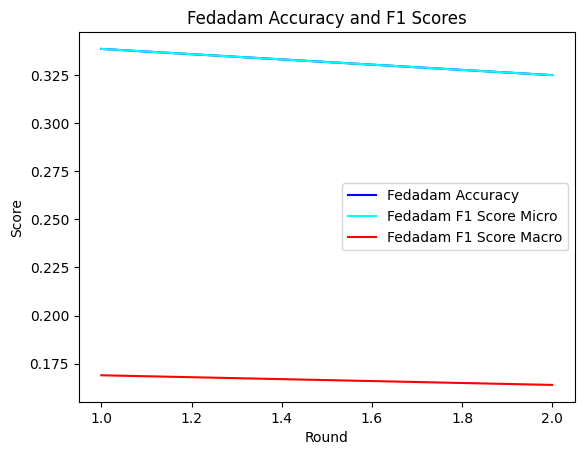

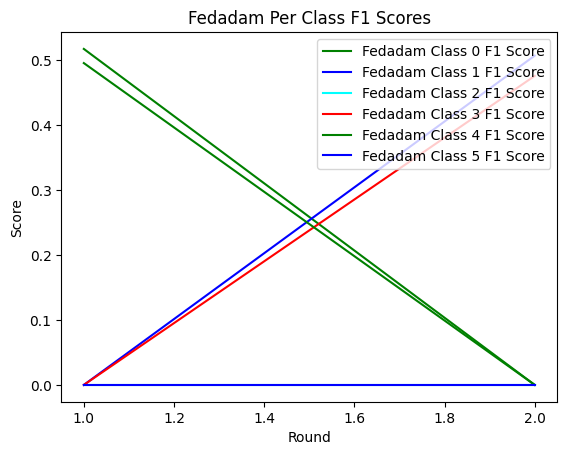

INFO flwr 2023-06-29 15:11:46,938 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=2, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=2, round_timeout=None)



Analyzing Strategy... :  Fedyogi
(launch_and_fit pid=7865) The target epsilon was: 10
(launch_and_fit pid=7865) The final epsilon is: 9.995721631459373
(launch_and_evaluate pid=7865) [Client 0] evaluate, config: {} [repeated 3x across cluster]
(launch_and_evaluate pid=7865) [Client 0] loss: 8.376950131450101, accuracy: 0.32697547683923706, f1_score_micro: 0.32697547683923706, f1_score_macro: 0.16517538189364814, f1_score_perclass: [0.         0.52488688 0.         0.46616541 0.         0.        ] [repeated 3x across cluster]


(launch_and_fit pid=7865) /usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(launch_and_fit pid=7865)   warnings.warn( [repeated 2x across cluster]
(launch_and_fit pid=7865) /usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
(launch_and_fit pid=7865) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
(laun

(launch_and_fit pid=8594) [Client 2] fit, config: {}


(launch_and_fit pid=8594) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
(launch_and_fit pid=8594)   warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


(launch_and_fit pid=8594) The target epsilon was: 10
(launch_and_fit pid=8594) The final epsilon is: 9.995721631459373
(launch_and_fit pid=8595) The final epsilon is: 9.995721631459373
(launch_and_fit pid=8594) [Client 3] fit, config: {}
(launch_and_fit pid=8594) The target epsilon was: 10 [repeated 2x across cluster]
(launch_and_fit pid=8594) The final epsilon is: 9.995721631459373 [repeated 2x across cluster]
(launch_and_fit pid=8595) The final epsilon is: 9.995721631459373


DEBUG flwr 2023-06-29 15:12:49,216 | server.py:232 | fit_round 1 received 4 results and 0 failures
DEBUG:flwr:fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-06-29 15:12:49,257 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-29 15:12:49,273 | server.py:168 | evaluate_round 1: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 1: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-06-29 15:12:49,812 | server.py:182 | evaluate_round 1 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 4 results and 0 failures
DEBUG flwr 2023-06-29 15:12:49,821 | server.py:218 | fit_round 2: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 2: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=8594) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=8594) [Client 3] loss: 0.025291529598288055, accuracy: 0.5340599455040872, f1_score_micro: 0.5340599455040872, f1_score_macro: 0.3748255538066154, f1_score_perclass: [0.51282051 0.         0.         0.0952381  0.73291925 0.90797546]


(launch_and_fit pid=8594) /usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on. [repeated 2x across cluster]
(launch_and_fit pid=8594)   warnings.warn( [repeated 3x across cluster]
(launch_and_fit pid=8595)   warnings.warn(
(launch_and_fit pid=8595)   warnings.warn(
(launch_and_fit pid=8595)   warnings.warn(
(launch_and_fit pid=8594) /usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.


(launch_and_fit pid=8594) [Client 2] fit, config: {}


(launch_and_fit pid=8595) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
(launch_and_fit pid=8595)   warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


(launch_and_fit pid=8594) The target epsilon was: 10 [repeated 2x across cluster]
(launch_and_fit pid=8594) The final epsilon is: 9.995721631459373 [repeated 2x across cluster]
(launch_and_evaluate pid=8595) [Client 1] evaluate, config: {} [repeated 3x across cluster]
(launch_and_evaluate pid=8595) [Client 1] loss: 0.025175860857119026, accuracy: 0.5449591280653951, f1_score_micro: 0.5449591280653951, f1_score_macro: 0.3703396724816712, f1_score_perclass: [0.52682927 0.         0.         0.07894737 0.72340426 0.89285714] [repeated 3x across cluster]
(launch_and_fit pid=8595) The final epsilon is: 9.995721631459373
(launch_and_fit pid=8594) [Client 3] fit, config: {}


DEBUG flwr 2023-06-29 15:13:33,056 | server.py:232 | fit_round 2 received 4 results and 0 failures
DEBUG:flwr:fit_round 2 received 4 results and 0 failures
DEBUG flwr 2023-06-29 15:13:33,096 | server.py:168 | evaluate_round 2: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 2: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=8594) The target epsilon was: 10 [repeated 2x across cluster]
(launch_and_fit pid=8594) The final epsilon is: 9.995721631459373 [repeated 2x across cluster]
(launch_and_fit pid=8595) The final epsilon is: 9.995721631459373


DEBUG flwr 2023-06-29 15:13:33,514 | server.py:182 | evaluate_round 2 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 4 results and 0 failures
INFO flwr 2023-06-29 15:13:33,518 | server.py:147 | FL finished in 99.21616161099996
INFO:flwr:FL finished in 99.21616161099996
INFO flwr 2023-06-29 15:13:33,520 | app.py:218 | app_fit: losses_distributed [(1, 0.025267610595401696), (2, 0.019041358774949158)]
INFO:flwr:app_fit: losses_distributed [(1, 0.025267610595401696), (2, 0.019041358774949158)]
INFO flwr 2023-06-29 15:13:33,523 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-29 15:13:33,525 | app.py:220 | app_fit: metrics_distributed {'accuracy': [(1, 0.532016348773842), (2, 0.5340599455040872)], 'f1_score_micro': [(1, 0.532016348773842), (2, 0.5340599455040872)], 'f1_score_macro': [(1, 0.36889785913098505), (2, 0.36160085677066495)], 'f1_score_perclass': [(1, [0.5166492705991951, 0.0, 0.0, 0.07901968

(launch_and_evaluate pid=8594) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=8594) [Client 1] loss: 0.01894386587740615, accuracy: 0.547683923705722, f1_score_micro: 0.547683923705722, f1_score_macro: 0.3635454012075215, f1_score_perclass: [0.52682927 0.         0.         0.         0.69902913 0.95541401]
(launch_and_evaluate pid=8594) [Client 0] loss: 0.019031660108540297, accuracy: 0.5422343324250681, f1_score_micro: 0.5422343324250681, f1_score_macro: 0.36503580503580507, f1_score_perclass: [0.52252252 0.         0.         0.         0.70769231 0.96      ]


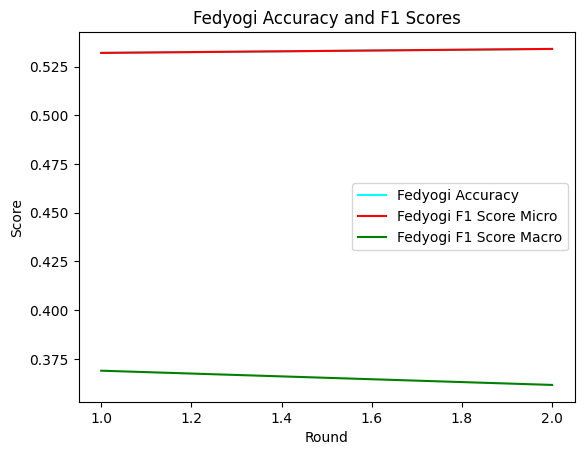

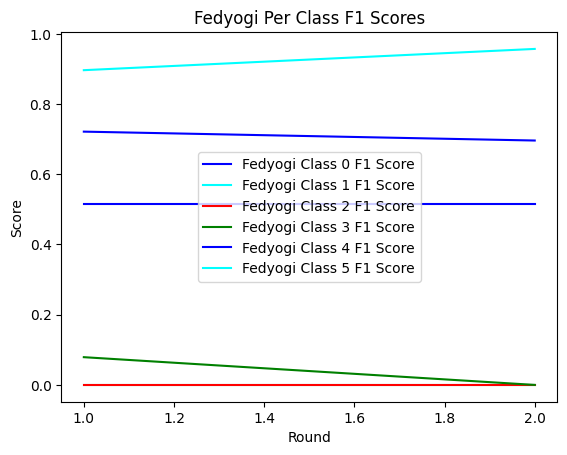

In [20]:
# how to aggregate custom evaluation results https://flower.dev/docs/save-progress.html
from typing import NewType

Scalar = NewType("Scalar", float)
model_metrics = {}


def custom_aggregate_evaluate(
        rnd: int,
        results: List[Tuple[fl.server.client_proxy.ClientProxy , fl.common.EvaluateRes]],
        failures: List[BaseException],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:

    if not results:
        return None, {}

    weights, losses, metrics = zip(*[(r.num_examples, r.loss, r.metrics) for _, r in results])

    total_weight = sum(weights)

    weighted_loss_sum = sum(w * l for w, l in zip(weights, losses))

    loss = weighted_loss_sum / total_weight

    aggregated_metrics = {}
    num_classes = len(results[0][1].metrics.get('f1_score_perclass', []))

    for metric_name in results[0][1].metrics:
        if metric_name != "f1_score_perclass":
            metric_sum = sum(
                r.metrics.get(metric_name, 0) * r.num_examples for _, r in results
            )
            aggregated_metric = metric_sum / total_weight
            aggregated_metrics[metric_name] = aggregated_metric
        else:
            # Calculate weighted F1 scores for each class
            per_class_f1_scores = [r.metrics.get(metric_name, [0]*num_classes) for _, r in results]
            per_class_f1_scores_weighted_sum = [
                sum(w * class_f1_score for w, class_f1_score in zip(weights, class_f1_scores))
                for class_f1_scores in zip(*per_class_f1_scores)
            ]
            aggregated_per_class_f1_scores = [weighted_sum / total_weight for weighted_sum in per_class_f1_scores_weighted_sum]
            aggregated_metrics[metric_name] = aggregated_per_class_f1_scores

    # Return aggregated loss and metrics (i.e., aggregated accuracy and F1 score)
    return loss, aggregated_metrics






loop_list = strategy_list

if loop_on_strategies is False:
  loop_list = [strategy_type]

for strategy_type in loop_list:
  print("\nAnalyzing Strategy... : ", strategy_type.capitalize())

  # Crea un'istanza del modello e ne ottiene i parametri
  if dataset == "cifar10":
    params = get_parameters(ConvNet())
  elif dataset == "har":
    params = get_parameters(MLP())

  if strategy_type == strategy_list[0]:
    # Creazione della Strategia FedAvg
    # Passa i parametri alla strategia per l'inizializzazione dei parametri lato Server
    strategy = fl.server.strategy.FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=1,
        min_fit_clients=n_clients,
        min_evaluate_clients=n_clients,
        min_available_clients=n_clients,
        initial_parameters=fl.common.ndarrays_to_parameters(params),
    )

  if strategy_type == strategy_list[1]:
    # Creazione della Strategia FedAdagrad
    strategy = fl.server.strategy.FedAdagrad(
        fraction_fit=1.0,
        fraction_evaluate=1,
        min_fit_clients=n_clients,
        min_evaluate_clients=n_clients,
        min_available_clients=n_clients,
        initial_parameters=fl.common.ndarrays_to_parameters(params),
    )

  if strategy_type == strategy_list[2]:
    # Creazione della Strategia FedAdam
    strategy = fl.server.strategy.FedAdam(
        fraction_fit=1.0,
        fraction_evaluate=1,
        min_fit_clients=n_clients,
        min_evaluate_clients=n_clients,
        min_available_clients=n_clients,
        initial_parameters=fl.common.ndarrays_to_parameters(params),
    )

  if strategy_type == strategy_list[3]:
    # Creazione della Strategia FedYogi
    # Passa i parametri alla strategia per l'inizializzazione dei parametri lato Server
    strategy = fl.server.strategy.FedYogi(
        fraction_fit=1.0,
        fraction_evaluate=1,
        min_fit_clients=n_clients,
        min_evaluate_clients=n_clients,
        min_available_clients=n_clients,
        initial_parameters=fl.common.ndarrays_to_parameters(params),
    )

  strategy.aggregate_evaluate = custom_aggregate_evaluate

  # Specifica le risorse del client se si ha bisogno della GPU (default a 1 per CPU e 0 per GPU)
  client_resources = None
  if DEVICE.type == "cuda":
      client_resources = {"num_gpus": 1}

  # Avvio della Simulazione
  history = fl.simulation.start_simulation(
      client_fn=client_fn,
      num_clients=n_clients,
      config=fl.server.ServerConfig(num_rounds=n_rounds),
      strategy=strategy,
      client_resources=client_resources,
  )

  aggregated_metrics = history.metrics_distributed


  acc = [m[1] for m in history.metrics_distributed['accuracy']]
  f1_scores_micro = [m[1] for m in history.metrics_distributed['f1_score_micro']]
  f1_scores_macro = [m[1] for m in history.metrics_distributed['f1_score_macro']]
  f1_scores_perclass = [m[1] for m in history.metrics_distributed['f1_score_perclass']]
  rounds = [m[0] for m in history.metrics_distributed['accuracy']]

  model_metrics[strategy_type] = {'accuracy': acc, 'f1_score_micro': f1_scores_micro, 'f1_score_macro': f1_scores_macro, 'f1_score_perclass': f1_scores_perclass}

  # Plot the accuracy and F1 scores
  plt.figure()
  plt.plot(rounds, acc, label=strategy_type.capitalize()+' Accuracy', color = strategy_colors[loop_list.index(strategy_type)])
  plt.plot(rounds, f1_scores_micro, label=strategy_type.capitalize()+' F1 Score Micro', color = strategy_colors[(loop_list.index(strategy_type) + 1) % len(strategy_colors)])
  plt.plot(rounds, f1_scores_macro, label=strategy_type.capitalize()+' F1 Score Macro', color = strategy_colors[(loop_list.index(strategy_type) + 2) % len(strategy_colors)])

  plt.legend()
  plt.title(strategy_type.capitalize() + " Accuracy and F1 Scores")
  plt.xlabel("Round")  # Added x-label
  plt.ylabel("Score")  # Added y-label
  plt.savefig("./"+strategy_type+"_acc_f1.png", dpi = 300)
  plt.show()
  plt.close()

  # Plot each class' F1 score in a new figure
  plt.figure()
  for i, class_f1_scores in enumerate(zip(*f1_scores_perclass)):
      plt.plot(rounds, class_f1_scores, label=strategy_type.capitalize()+f' Class {i} F1 Score', color = strategy_colors[(loop_list.index(strategy_type) + 3 + i) % len(strategy_colors)])

  plt.legend()
  plt.title(strategy_type.capitalize() + " Per Class F1 Scores")
  plt.xlabel("Round")  # Added x-label
  plt.ylabel("Score")  # Added y-label
  plt.savefig("./"+strategy_type+"_perclass_f1.png", dpi = 300)
  plt.show()
  plt.close()

  strategies_acc.append((strategy_type, max(acc), acc[-1], max(f1_scores_micro), f1_scores_micro[-1], max(f1_scores_macro), f1_scores_macro[-1]))



In [21]:
strategies_acc

[('fedavg',
  0.611716621253406,
  0.611716621253406,
  0.611716621253406,
  0.611716621253406,
  0.515369074005597,
  0.515369074005597),
 ('fedadagrad',
  0.33310626702997276,
  0.32152588555858314,
  0.33310626702997276,
  0.32152588555858314,
  0.18348633054851282,
  0.16158915111805244),
 ('fedadam',
  0.33855585831062673,
  0.3249318801089918,
  0.33855585831062673,
  0.3249318801089918,
  0.16895982948080693,
  0.16395113962464217),
 ('fedyogi',
  0.5340599455040872,
  0.5340599455040872,
  0.5340599455040872,
  0.5340599455040872,
  0.36889785913098505,
  0.36160085677066495)]

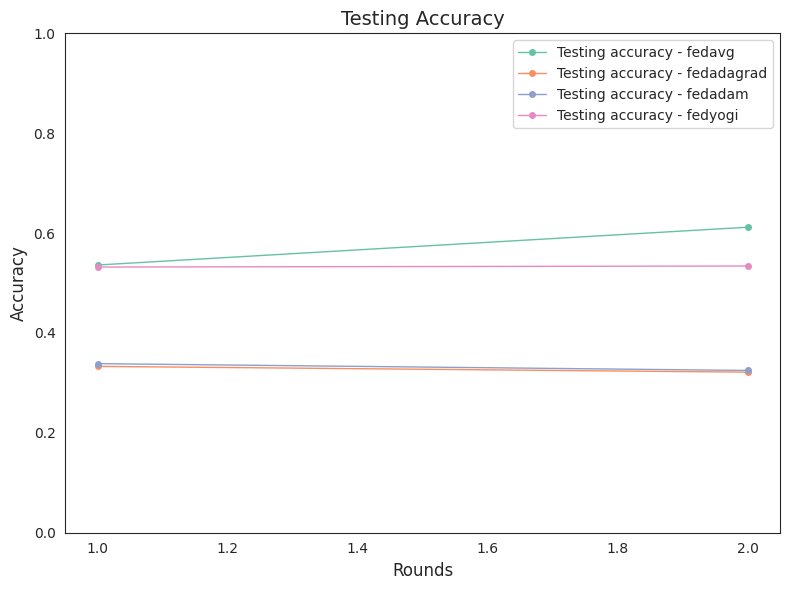

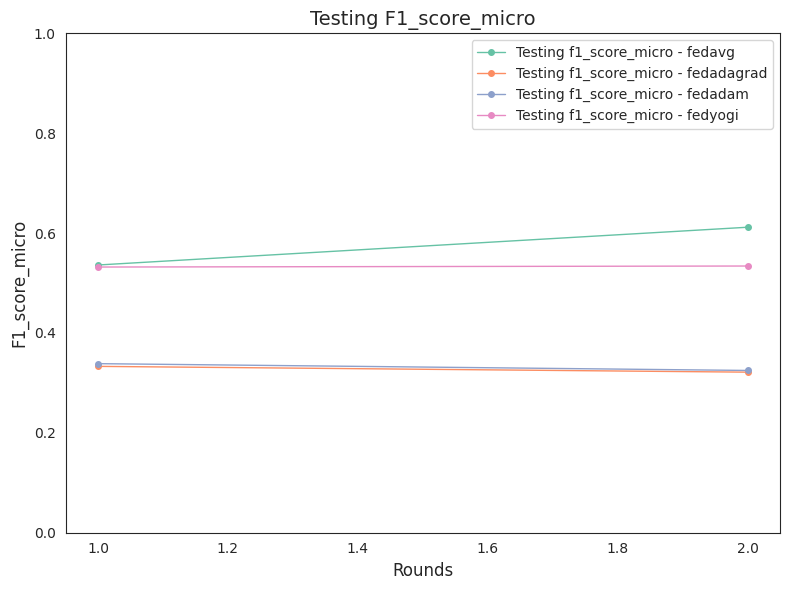

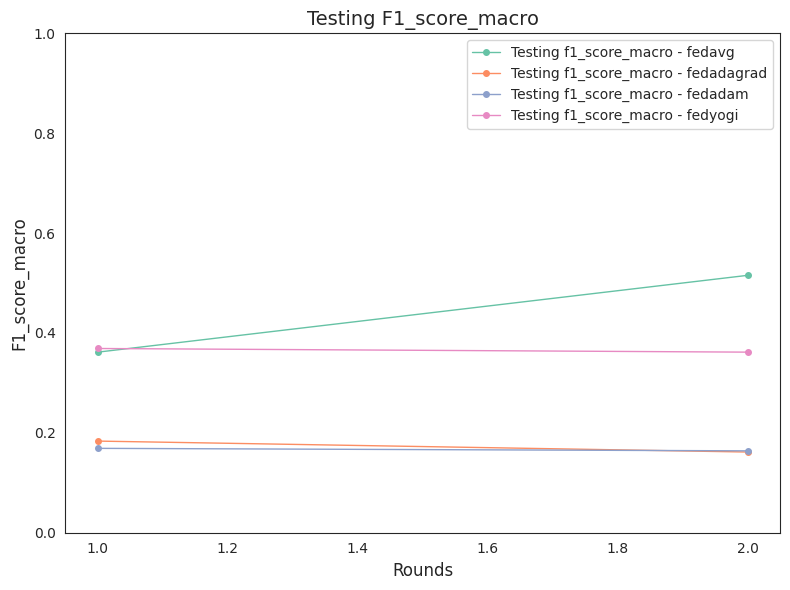

In [25]:
# Seaborn plot settings
sns.set_style("white")
palette = sns.color_palette("Set2")

# List of metrics to plot
metrics_to_plot = ['accuracy', 'f1_score_micro', 'f1_score_macro']

# Iterate over each metric
for metric in metrics_to_plot:
    fig, ax = plt.subplots(figsize=(8, 6))
    for idx, (strategy, metrics) in enumerate(model_metrics.items()):
        metric_scores = metrics[metric]
        rounds = list(range(1, len(metric_scores) + 1))
        ax.plot(rounds, metric_scores, marker='o', markersize=4, linestyle='-', linewidth=1, color=palette[idx], label='Testing ' + metric + ' - ' + strategy)
    ax.set_ylim(bottom=0, top=1)  # Ensure the y-axis range is [0, 1]
    ax.set_title('Testing ' + metric.capitalize(), fontsize=14)
    ax.set_xlabel('Rounds', fontsize=12)
    ax.set_ylabel(metric.capitalize(), fontsize=12)
    ax.legend()
    plt.tight_layout()
    plt.savefig("./fl_" + metric + "_over_strategies.png", dpi=300)
    plt.show()


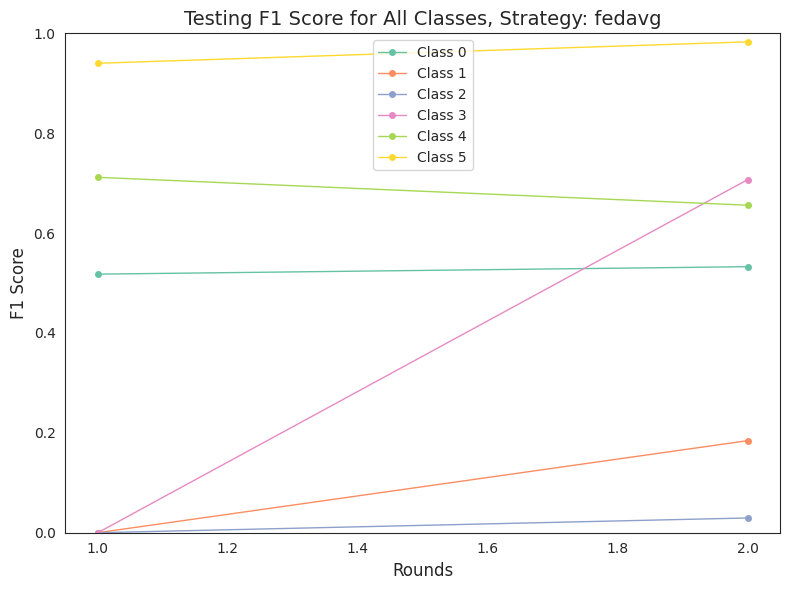

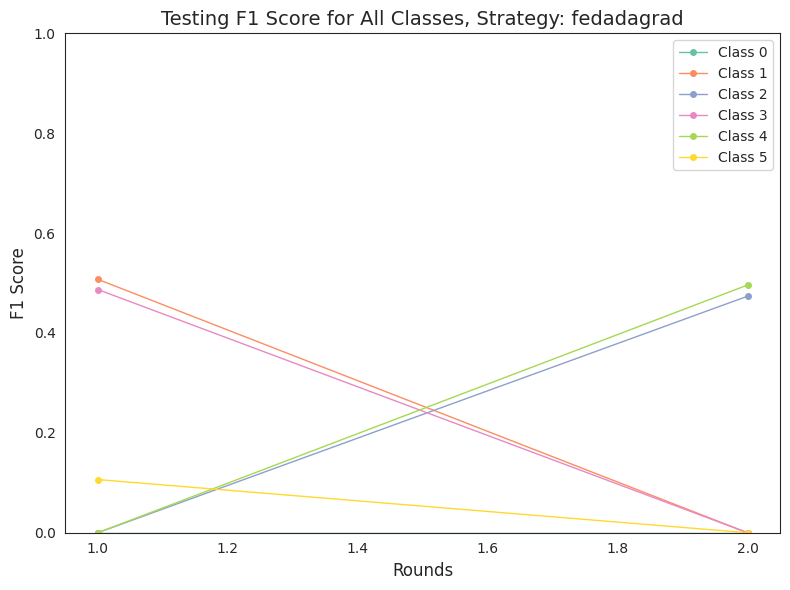

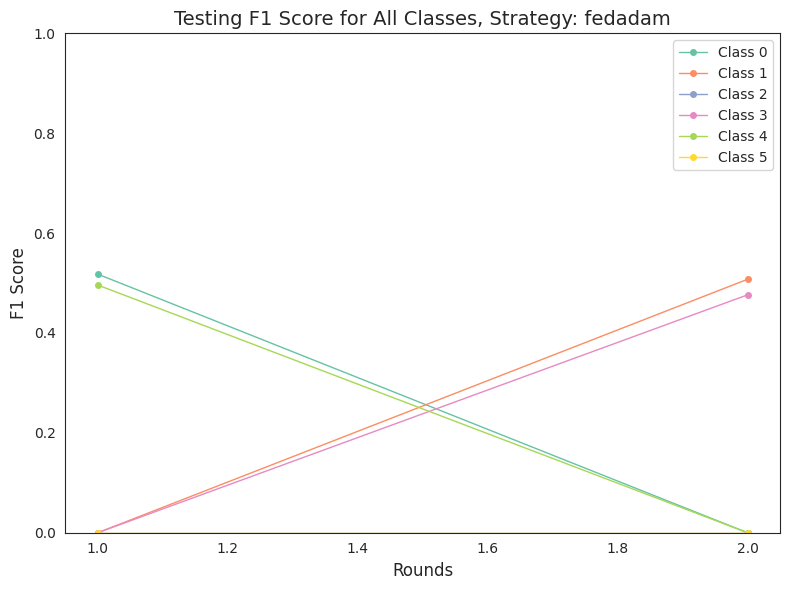

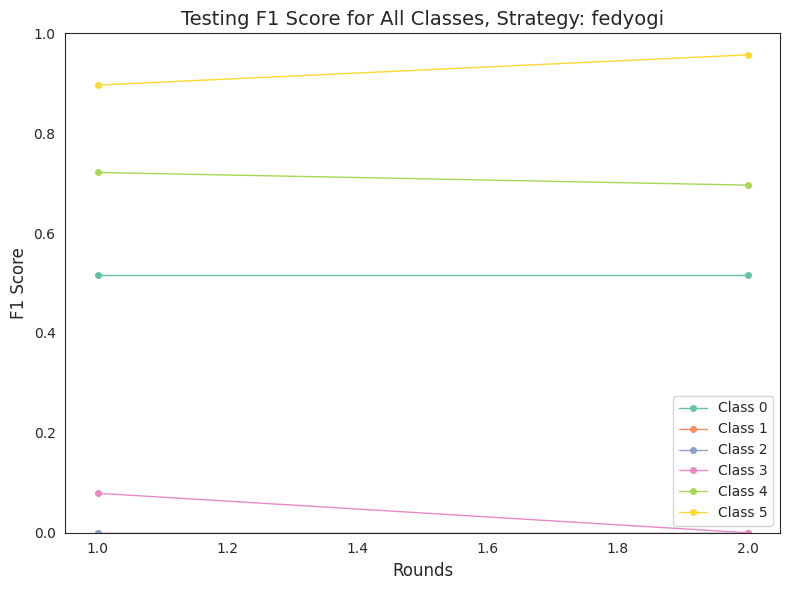

In [32]:
# Loop through each strategy
for strategy, metrics in model_metrics.items():

    # Get F1 scores per class
    f1_scores_perclass = metrics['f1_score_perclass']

    # Assume that f1_scores_perclass is a list of lists
    # where each sublist is a list of F1 scores for each class for a particular round
    num_classes = len(f1_scores_perclass[0])
    num_rounds = len(f1_scores_perclass)

    # Create rounds list
    rounds = list(range(1, num_rounds + 1))

    # Create a subplot for this strategy
    fig, ax = plt.subplots(figsize=(8, 6))

    # For each class
    for class_idx in range(num_classes):
        # Extract F1 scores for this class across all rounds
        class_f1_scores = [round_f1_scores[class_idx] for round_f1_scores in f1_scores_perclass]
        # Plot
        ax.plot(rounds, class_f1_scores, marker='o', markersize=4, linestyle='-', linewidth=1, color=palette[class_idx], label='Class ' + str(class_idx))

    ax.set_ylim(bottom=0, top=1)
    ax.set_title(f'Testing F1 Score for All Classes, Strategy: {strategy}', fontsize=14)
    ax.set_xlabel('Rounds', fontsize=12)
    ax.set_ylabel('F1 Score', fontsize=12)
    ax.legend()

    plt.tight_layout()
    plt.savefig(f"./fl_f1score_perclass_{strategy}.png", dpi=300)
    plt.show()


In [ ]:
strategies_acc_df = pd.DataFrame(strategies_acc, columns=['Strategy', 'Max Accuracy', 'Last Accuracy', 'Max F1 Score', 'Last F1 Score'])

# Set the width of the bars
bar_width = 0.4

# Create the positions of the bars
r1 = np.arange(len(strategies_acc_df))
r2 = [x + bar_width for x in r1]

# Create the first plot for Accuracy
plt.figure(figsize=(10, 5))
plt.bar(r1, strategies_acc_df['Max Accuracy'], width=bar_width, label='Max Accuracy')
plt.bar(r2, strategies_acc_df['Last Accuracy'], width=bar_width, label='Last Accuracy')
plt.xlabel('Strategy')
plt.ylabel('Accuracy')
plt.title('Max Accuracy and Last Accuracy for Different Strategies')
plt.xticks([r + bar_width / 2 for r in range(len(strategies_acc_df))], strategies_acc_df['Strategy'])
plt.legend()
plt.tight_layout()
plt.savefig("./fl_accuracy_bar_over_strategies.png", dpi=300)
plt.show()

# Create the second plot for F1 Score
plt.figure(figsize=(10, 5))
plt.bar(r1, strategies_acc_df['Max F1 Score'], width=bar_width, label='Max F1 Score')
plt.bar(r2, strategies_acc_df['Last F1 Score'], width=bar_width, label='Last F1 Score')
plt.xlabel('Strategy')
plt.ylabel('F1 Score')
plt.title('Max F1 Score and Last F1 Score for Different Strategies')
plt.xticks([r + bar_width / 2 for r in range(len(strategies_acc_df))], strategies_acc_df['Strategy'])
plt.legend()
plt.tight_layout()
plt.savefig("./fl_f1score_bar_over_strategies.png", dpi=300)
plt.show()


## Build a Strategy from scratch

Let’s overwrite the `configure_fit` method such that it passes a higher learning rate (potentially also other hyperparameters) to the optimizer of a fraction of the clients. We will keep the sampling of the clients as it is in `FedAvg` and then change the configuration dictionary (one of the `FitIns` attributes).

In [ ]:
'''
from typing import Callable, Union

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg


class FedCustom(fl.server.strategy.Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients

    def __repr__(self) -> str:
        return "FedCustom"

    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        return fl.common.ndarrays_to_parameters(ndarrays)

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""

        # Sample clients
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Create custom configs
        n_clients = len(clients)
        half_clients = n_clients // 2
        standard_config = {"lr": 0.001}
        higher_lr_config = {"lr": 0.003}
        fit_configurations = []
        for idx, client in enumerate(clients):
            if idx < half_clients:
                fit_configurations.append((client, FitIns(parameters, standard_config)))
            else:
                fit_configurations.append(
                    (client, FitIns(parameters, higher_lr_config))
                )
        return fit_configurations

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""

        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}

        """Aggregate fit results using weighted average."""
        '''
'''
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
'''
'''
        return parameters_aggregated, metrics_aggregated

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Evaluate global model parameters using an evaluation function."""

        # Let's assume we won't perform the global model evaluation on the server side.
        return None

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients


fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=2,
    config=fl.server.ServerConfig(num_rounds=3),
    strategy=FedCustom(),  # <-- pass the new strategy here
    client_resources=client_resources,
)
'''

The only thing left is to use the newly created custom Strategy `FedCustom` when starting the experiment: